# 3. Práctica: Vectores a palabras

Castañeda Mora, Carlos

**Fecha de entrega: 16 de Marzo de 2025 @ 11:59pm**

Obtenga la matriz de co-ocurrencia para un corpus en español y realice los siguientes calculos:
- Las probabilidades conjuntas
$$p(w_i,w_j) = \frac{c_{i,j}}{\sum_i \sum_j c_{i,j}}$$
- Las probabilidades marginales
$$p(w_i) = \sum_j p(w_i,w_j)$$
- Positive Point Wise Mutual Information (PPMI):
$$PPMI(w_i,w_j) = \max\{0, \log_2 \frac{p(w_i,w_j)}{p(w_i)p(w_j)}\}$$

**Comparación de representaciones**

Aplica reducción de dimensionalidad (a 2D) de los vectores de la matríz con PPMI y de los vectores entrenados en español:

- Realiza un plot de 100 vectores aleatorios (que esten tanto en la matríz como en los vectores entrenados)
- Compara los resultados de los plots:
    - ¿Qué representación dirías que captura mejor relaciones semánticas?
    - Realiza un cuadro comparativo de ambos métodos con ventajas/desventajas

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import defaultdict, Counter
from gensim.models import Word2Vec
import os
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import random
import logging

# Configuración inicial
nltk.download('punkt')
nltk.download("punkt_tab")
nltk.download('stopwords')
np.random.seed(42)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


# 1. Clase para extraer oraciones de Wikipedia
class WikiSentencesExtractor:
    def __init__(self, directory: str, max_lines: int):
        self.directory = directory
        self.max_lines = max_lines

    @staticmethod
    def preprocess(text: str) -> list:
        if len(text) <= 3 or text.startswith("<"):
            return []
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        words = word_tokenize(text, language="spanish")
        stop_words = set(stopwords.words("spanish"))
        words = [token for token in words if token not in stop_words]
        words = [token for token in words if token.isalpha() and len(token) > 2]
        return words

    def __iter__(self):
        total_sent_iterator = 0
        for subdir_letter in os.listdir(self.directory):
            file_path = os.path.join(self.directory, subdir_letter)
            for file_name in os.listdir(file_path):
                with open(os.path.join(file_path, file_name), 'r', encoding='utf-8') as file:
                    for line in file:
                        if total_sent_iterator == self.max_lines:
                            return
                        words = self.preprocess(line)
                        if words:
                            total_sent_iterator += 1
                            yield words

# 2. Construir matriz de co-ocurrencia
def build_cooccurrence_matrix(sentences, window_size=5, min_freq=10):
    word_freq = Counter()
    for sentence in sentences:
        word_freq.update(sentence)
    
    # Filtrar palabras poco frecuentes
    vocabulary = {word for word, count in word_freq.items() if count >= min_freq}
    vocab_list = sorted(vocabulary)
    word2idx = {word: idx for idx, word in enumerate(vocab_list)}
    
    # Inicializar matriz de co-ocurrencia
    cooccur_matrix = np.zeros((len(vocabulary), len(vocabulary)))
    
    # Llenar la matriz
    for sentence in sentences:
        words = [w for w in sentence if w in vocabulary]
        for i, center_word in enumerate(words):
            start = max(0, i - window_size)
            end = min(len(words), i + window_size + 1)
            for j in range(start, end):
                if i != j:
                    context_word = words[j]
                    cooccur_matrix[word2idx[center_word], word2idx[context_word]] += 1
    return cooccur_matrix, word2idx, vocab_list

# 3. Calcular probabilidades y PPMI
def calculate_ppmi(cooccur_matrix, epsilon=1e-8):
    total = np.sum(cooccur_matrix)
    joint_prob = cooccur_matrix / total
    marginal_prob_rows = np.sum(joint_prob, axis=1)
    marginal_prob_cols = np.sum(joint_prob, axis=0)
    
    ppmi_matrix = np.zeros_like(cooccur_matrix, dtype=np.float32)
    for i in range(cooccur_matrix.shape[0]):
        for j in range(cooccur_matrix.shape[1]):
            pmi = np.log2(joint_prob[i, j] / (marginal_prob_rows[i] * marginal_prob_cols[j] + epsilon) + epsilon)
            ppmi_matrix[i, j] = max(0, pmi)
    return ppmi_matrix

# 4. Reducción de dimensionalidad con PCA
def reduce_dimensions(vectors, n_components=2):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(vectors)

# 5. Cargar modelo Word2Vec pre-entrenado
def load_word2vec_model(model_path):
    return Word2Vec.load(model_path)

# 6. Visualización
def plot_vectors(vectors, words, title, figsize=(14, 12), fontsize=10):
    plt.figure(figsize=figsize)
    plt.scatter(vectors[:, 0], vectors[:, 1], alpha=0.6)
    
    # Anotar palabras
    for i, word in enumerate(words):
        plt.annotate(word, (vectors[i, 0], vectors[i, 1]), fontsize=fontsize)
    
    plt.title(title, fontsize=16)
    plt.xlabel('Componente Principal 1', fontsize=14)
    plt.ylabel('Componente Principal 2', fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     /home/carloscmora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/carloscmora/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/carloscmora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from gensim.models import word2vec
#  PARÁMETROS CONFIGURABLES 
N_SENTENCES = 100000  # Número de oraciones a procesar
WINDOW_SIZE = 5       # Tamaño de ventana para co-ocurrencia
MIN_FREQ = 10         # Frecuencia mínima para incluir palabra
MODEL_PATH = "/home/carloscmora/lcd/nlp2/models/word2vec/eswiki-test-md.model" # Ruta al modelo
DUMP_DIR = "/home/carloscmora/lcd/nlp2/models/word2vec/eswiki-dump3"  # Ruta al corpus


# 1. Cargar oraciones
print("Cargando corpus...")
sentences_extractor = WikiSentencesExtractor(DUMP_DIR, N_SENTENCES)
sentences = list(sentences_extractor)
print(f"Oraciones procesadas: {len(sentences)}")

# 2. Construir matriz de co-ocurrencia
print("Construyendo matriz de co-ocurrencia...")
cooccur_matrix, word2idx, vocab_list = build_cooccurrence_matrix(
    sentences, 
    window_size=WINDOW_SIZE,
    min_freq=MIN_FREQ
)
print(f"Matriz de co-ocurrencia: {cooccur_matrix.shape}")

# 3. Calcular PPMI
print("Calculando PPMI...")
ppmi_matrix = calculate_ppmi(cooccur_matrix)





Cargando corpus...
Oraciones procesadas: 100000
Construyendo matriz de co-ocurrencia...
Matriz de co-ocurrencia: (22672, 22672)
Calculando PPMI...


2025-06-06 00:38:51,851 : INFO : loading Word2Vec object from /home/carloscmora/lcd/nlp2/models/word2vec/eswiki-test-md.model
2025-06-06 00:38:51,904 : INFO : loading wv recursively from /home/carloscmora/lcd/nlp2/models/word2vec/eswiki-test-md.model.wv.* with mmap=None
2025-06-06 00:38:51,906 : INFO : loading vectors from /home/carloscmora/lcd/nlp2/models/word2vec/eswiki-test-md.model.wv.vectors.npy with mmap=None


Cargando modelo Word2Vec...


2025-06-06 00:38:52,060 : INFO : loading syn1neg from /home/carloscmora/lcd/nlp2/models/word2vec/eswiki-test-md.model.syn1neg.npy with mmap=None
2025-06-06 00:38:52,213 : INFO : setting ignored attribute cum_table to None
2025-06-06 00:38:53,281 : INFO : Word2Vec lifecycle event {'fname': '/home/carloscmora/lcd/nlp2/models/word2vec/eswiki-test-md.model', 'datetime': '2025-06-06T00:38:53.281618', 'gensim': '4.3.3', 'python': '3.9.20 (main, Oct  3 2024, 07:27:41) \n[GCC 11.2.0]', 'platform': 'Linux-6.6.87.1-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'loaded'}


Modelo cargado: /home/carloscmora/lcd/nlp2/models/word2vec/eswiki-test-md.model
Palabras comunes encontradas: 21886
Preparando vectores...
Reduciendo dimensionalidad...
Generando visualizaciones...


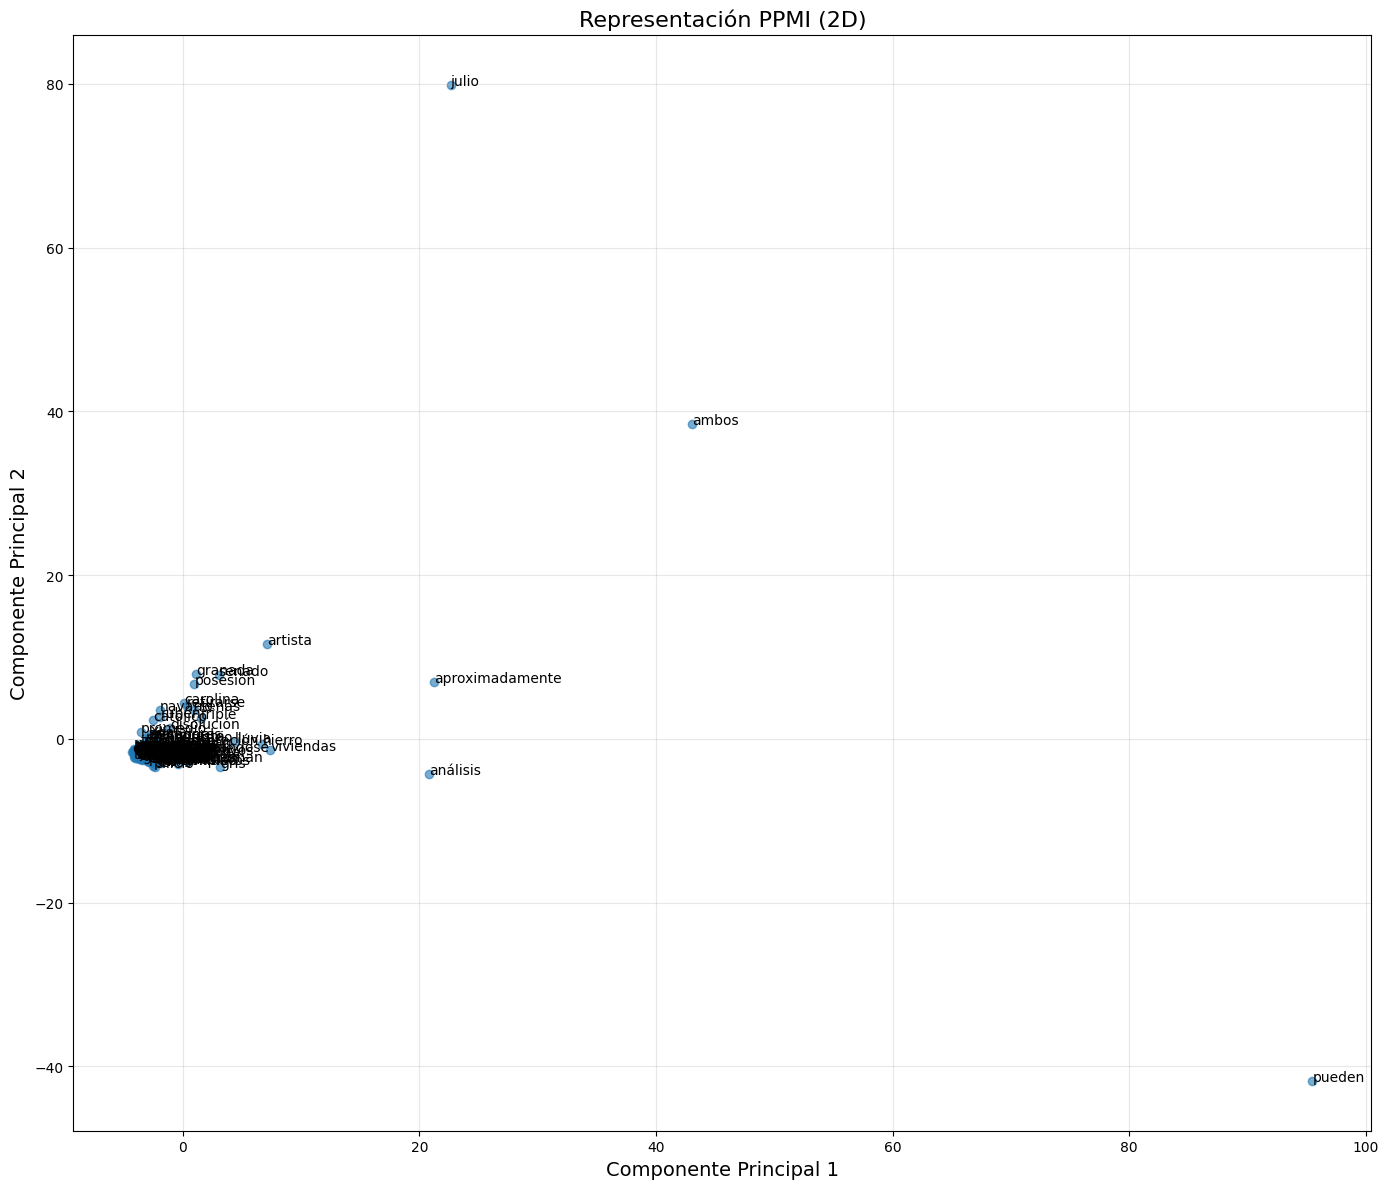

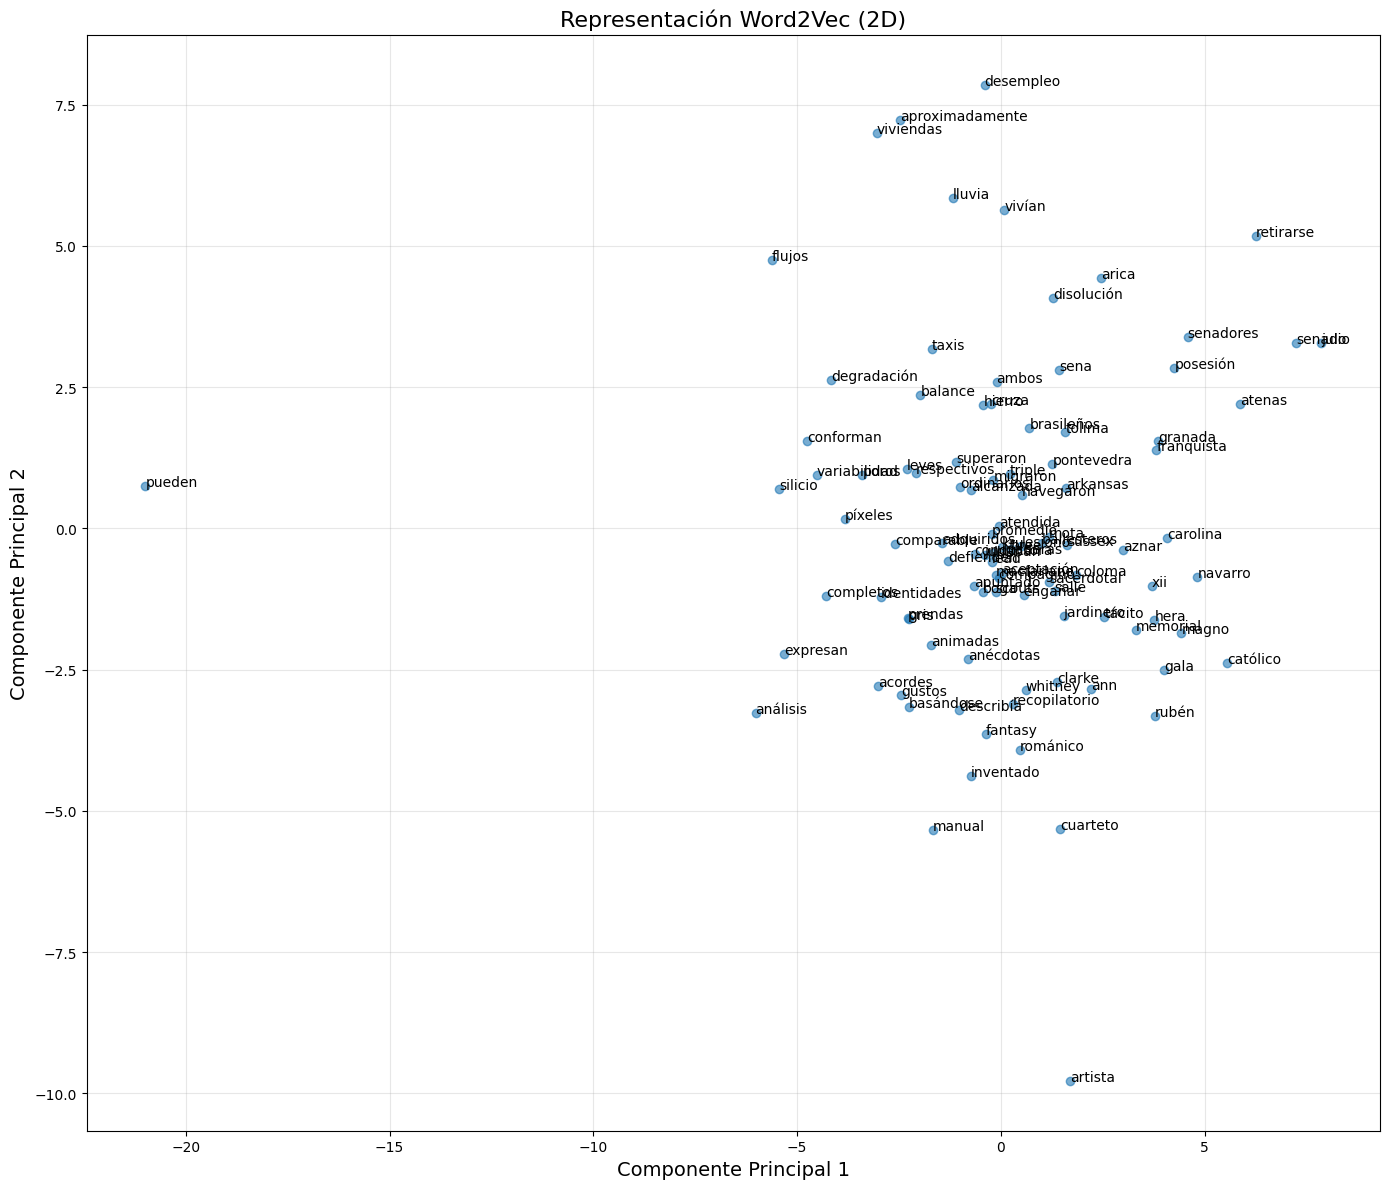

In [6]:
# 4. Cargar modelo Word2Vec
print("Cargando modelo Word2Vec...")
w2v_model = load_word2vec_model(MODEL_PATH)
w2v_vocab = set(w2v_model.wv.index_to_key)
print(f"Modelo cargado: {MODEL_PATH}")

# 5. Encontrar palabras comunes
common_words = list(set(vocab_list) & w2v_vocab)
print(f"Palabras comunes encontradas: {len(common_words)}")

# Seleccionar 100 palabras aleatorias
if len(common_words) < 100:
    print(f"Advertencia: Solo hay {len(common_words)} palabras comunes")
    selected_words = common_words
else:
    selected_words = random.sample(common_words, 100)

# 6. Preparar vectores para reducción
print("Preparando vectores...")
# Para PPMI
ppmi_vectors = np.array([ppmi_matrix[word2idx[word]] for word in selected_words])

# Para Word2Vec
w2v_vectors = np.array([w2v_model.wv[word] for word in selected_words])

# 7. Reducir dimensionalidad
print("Reduciendo dimensionalidad...")
ppmi_reduced = reduce_dimensions(ppmi_vectors)
w2v_reduced = reduce_dimensions(w2v_vectors)

# 8. Visualizar
print("Generando visualizaciones...")
plot_vectors(ppmi_reduced, selected_words, "Representación PPMI (2D)")
plot_vectors(w2v_reduced, selected_words, "Representación Word2Vec (2D)")


results = {
    'selected_words': selected_words,
    'ppmi_vectors': ppmi_vectors,
    'w2v_vectors': w2v_vectors,
    'ppmi_2d': ppmi_reduced,
    'w2v_2d': w2v_reduced
}


### Análisis de Resultados

La representación en dos dimensiones mediante reducción de dimensionalidad aplicada sobre los vectores de palabras entrenados con Word2Vec muestra una distribución relativamente compacta en torno a una región central del plano. A pesar de que algunas palabras se encuentran más dispersas (e.g., *pueden*, *artista*, *retirarse*), la mayoría de los vectores aparecen agrupados, lo cual es indicativo de una estructuración semántica subyacente.

Se observan clústeres implícitos de palabras con potencial relación semántica o sintáctica, como nombres propios, sustantivos geográficos o términos técnicos. Este patrón sugiere que Word2Vec ha capturado relaciones latentes que se reflejan en la cercanía espacial entre palabras afines. Lo anterior es consistente con la capacidad del modelo para aprender representaciones distribuidas que preservan información contextual derivada del corpus.

Comparado con representaciones obtenidas a partir de matrices de co-ocurrencia con PPMI, es común que Word2Vec produzca vectores de menor dimensionalidad y mejor comportamiento en tareas semánticas, dado que los métodos basados en predicción como Word2Vec tienden a superar a los basados en conteo en términos de generalización y compacidad. Adicionalmente, la dispersión de las palabras en la matriz PPMI suele ser mayor y menos estructurada, afectando negativamente la interpretación semántica de las distancias.

Por tanto, se puede concluir que Word2Vec ofrece una representación vectorial más eficiente y semánticamente significativa respecto a las relaciones entre palabras, al menos en el espacio reducido a dos dimensiones. Esto lo convierte en una opción preferente para tareas que requieren inferencia semántica o similitud léxica.



### Cuadro comparativo

| **Característica** | **Word2Vec**                                                                       | **Vectores con Matriz de Co-ocurrencias (PPMI)**                  |
| ------------------ | ---------------------------------------------------------------------------------- | ----------------------------------------------------------------- |
| **Ventajas**       | - Captura relaciones semánticas con mayor fidelidad.                               | - Sencillez conceptual y computacional.                           |
|                    | - Genera vectores densos y menos dispersos.                                        | - Ofrece cierta interpretabilidad explícita (frecuencia directa). |
|                    | - Permite ajustar la dimensionalidad.                                              | - No requiere entrenamiento supervisado.                          |
|                    | - Puede generalizar a palabras no vistas con ciertas extensiones (e.g., subwords). |                                                                   |
| **Desventajas**    | - Requiere corpus extenso para un entrenamiento de calidad.                        | - Vectores dispersos con muchos ceros (alta dimensionalidad).     |
|                    | - Costoso computacionalmente (entrenamiento por gradiente).                        | - Limitado en capturar relaciones semánticas profundas.           |
|                    | - Puede ser sensible a hiperparámetros y tamaño de ventana.                        | - Pobre manejo de palabras no vistas.                             |


